# OptOut Project R&R: Sample Selection

* Select main sample of women who became mothers before (<=) 1995. We previously had a criterion of first birth >= 1980 because we wanted to measure their traits at one year pre-birth, and NLSY79 is only available starting 1979. Following reviewer's suggestion, we are now including the younger mothers who gave birth before 1980 as well.
* Select robustness check sample of women who became mothers before (<=) 1999. This is for our analysis of 14-year-long sequences
* Dataset: NLSY79 (1979-2013)

In [1]:
#setup
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from collections import defaultdict

# set some nicer defaults for matplotlib
from matplotlib import rcParams

#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = False
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecessary plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

/Users/xzhuo/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Select sample based on dates of child birth

In [2]:
#read birth data
dob_df = pd.read_csv('../data/childbirth.csv')
print dob_df.shape
dob_df.head()

(12686, 26)


,caseid_1979,sample_id_1979,sample_race_1979,sample_sex_1979,c1dob_m_xrnd,c1dob_y_xrnd,c2dob_m_xrnd,c2dob_y_xrnd,c3dob_m_xrnd,c3dob_y_xrnd,...,c7dob_m_xrnd,c7dob_y_xrnd,c8dob_m_xrnd,c8dob_y_xrnd,c9dob_m_xrnd,c9dob_y_xrnd,c10dob_m_xrnd,c10dob_y_xrnd,c11dob_m_xrnd,c11dob_y_xrnd
0,1,5,3,2,-4,-4,-4,-4,-4,-4,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
1,2,5,3,2,3,1993,11,1994,-4,-4,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
2,3,5,3,2,6,1981,10,1983,4,1986,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
3,4,5,3,2,8,1980,3,1997,-4,-4,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
4,5,1,3,1,5,1989,-4,-4,-4,-4,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4


In [3]:
#drop males
#1-male; 2-female
sample_df = dob_df[dob_df.sample_sex_1979==2]
print sample_df.shape

(6283, 26)


In [4]:
#drop subsamples that weren’t followed over the entire survey period
print 'before dropping:', sample_df.sample_id_1979.unique()
sample_df = sample_df[(~sample_df.sample_id_1979.isin([9, 12, 15, 16, 17, 18, 19, 20]))]
print 'after dropping:', sample_df.sample_id_1979.unique()
print sample_df.shape

before dropping: [ 5  6  8  7 14 12 13 18 19 20]
after dropping: [ 5  6  8  7 14 13]
(4926, 26)


There are 4926 women in NLSY79.

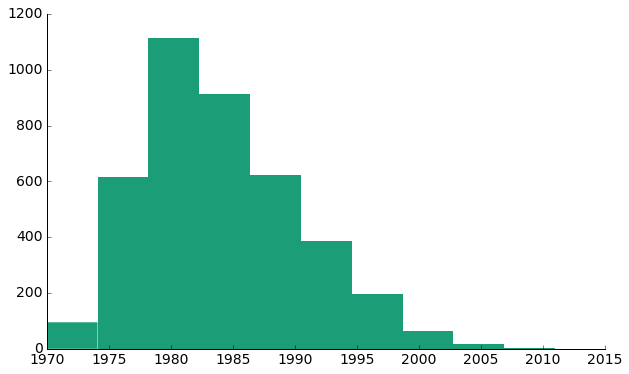

In [5]:
#distribution of child birth dates
plt.hist(sample_df.c1dob_y_xrnd[sample_df.c1dob_y_xrnd!=-4])
remove_border()

## Respondent's date of birth

In [6]:
dob_df = pd.read_csv('../data/dob.csv')
dob_df.head()

,caseid_1979,m_dob_1979,y_dob_1979,m_dob_1981,y_dob_1981
0,1,9,58,9,58
1,2,1,59,1,59
2,3,8,61,-5,-5
3,4,8,62,8,62
4,5,7,59,7,59


In [7]:
#is there missing dob reported in 1979? NO
missing79 = []
for i, row in dob_df.iterrows():
    if row['m_dob_1979']<=0 or row['y_dob_1979']<=0: 
        missing79.append(row)

print len(missing79)

0


In [8]:
#verify if dob reported in 1979 is the same as dob reported in 1981
diff= []
missing81 = []
for i, row in dob_df.iterrows():
    if row['m_dob_1981']>0 and row['y_dob_1981']>0: #if it's valid dob in 1981
        if row['m_dob_1979']!=row['m_dob_1981'] or row['y_dob_1979']!=row['y_dob_1981']:
            diff.append(row)
    else:
        missing81.append(row)

print '%s respondents had missing dob in 1981 survey'%len(missing81)
print '%s respondents had valid, but different (from 1979) dob in 1981 survey'%len(diff)

491 respondents had missing dob in 1981 survey
263 respondents had valid, but different (from 1979) dob in 1981 survey


In [9]:
# how are dob different in 1979 and 1981 (just show the first 15 cases)
# show the first 15 cases

i = 0
print '1979 birth month | year | 1981 birth month | year'
for row in diff:
    print row.values[1:]
    i += 1
    
    if i>=15:
        break

1979 birth month | year | 1981 birth month | year
[ 1 59 11 59]
[11 63  9 63]
[12 57 12 59]
[ 9 62  9 63]
[ 6 64  6 65]
[ 6 57  7 57]
[ 9 63  5 63]
[ 9 58 11 58]
[ 4 63  5 63]
[ 3 60  4 60]
[ 5 58  9 58]
[ 3 63  7 62]
[ 6 58  5 58]
[ 7 64  4 64]
[ 5 58  4 58]


Some people reported different birth months and some reported different birth years. **DECISION: USE DOB REPORTED IN 1979.**

In [10]:
#Use dob reported in 1979. What are the unique birth years present in the dataset?
dob_df.y_dob_1979.unique()

array([58, 59, 61, 62, 60, 64, 63, 57])

In [11]:
# add birth year and birth month
sample_df = sample_df.merge(dob_df[['caseid_1979', 'y_dob_1979', 'm_dob_1979']], on='caseid_1979')

# rename
sample_df = sample_df.rename(index=str, columns={"y_dob_1979": "y_dob", "m_dob_1979":"m_dob"})

In [12]:
# add 1900 to dob year
sample_df.y_dob = sample_df.y_dob.map(lambda x: x+1900)

In [13]:
#create a new column of the year in which R turns age 35
sample_df['y_age35'] = sample_df.y_dob.map(lambda x: x+35)

In [14]:
sample_df.head()

,caseid_1979,sample_id_1979,sample_race_1979,sample_sex_1979,c1dob_m_xrnd,c1dob_y_xrnd,c2dob_m_xrnd,c2dob_y_xrnd,c3dob_m_xrnd,c3dob_y_xrnd,...,c8dob_y_xrnd,c9dob_m_xrnd,c9dob_y_xrnd,c10dob_m_xrnd,c10dob_y_xrnd,c11dob_m_xrnd,c11dob_y_xrnd,y_dob,m_dob,y_age35
0,1,5,3,2,-4,-4,-4,-4,-4,-4,...,-4,-4,-4,-4,-4,-4,-4,1958,9,1993
1,2,5,3,2,3,1993,11,1994,-4,-4,...,-4,-4,-4,-4,-4,-4,-4,1959,1,1994
2,3,5,3,2,6,1981,10,1983,4,1986,...,-4,-4,-4,-4,-4,-4,-4,1961,8,1996
3,4,5,3,2,8,1980,3,1997,-4,-4,...,-4,-4,-4,-4,-4,-4,-4,1962,8,1997
4,8,6,3,2,3,1976,5,1979,9,1982,...,-4,-4,-4,-4,-4,-4,-4,1958,7,1993


## Determine last valid year and deceased year from reasons for non-interview variables 

In [21]:
#read reson-for-non-interview data
rni_df = pd.read_csv('../data/reasonnonint.csv')
rni_df.head()

,caseid_1979,rni_1980,rni_1981,rni_1982,rni_1983,rni_1984,rni_1985,rni_1986,rni_1987,rni_1988,...,rni_1996,rni_1998,rni_2000,rni_2002,rni_2004,rni_2006,rni_2008,rni_2010,rni_2012,rni_2014
0,1,61,-4,61,61,61,61,61,61,61,...,61,61,61,61,61,61,61,61,61,61
1,2,-4,-4,-4,-4,-4,-4,-4,-4,-4,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
2,3,-4,61,-4,-4,-4,-4,-4,-4,-4,...,-4,-4,-4,-4,64,-4,-4,61,-4,-4
3,4,66,-4,-4,-4,-4,-4,-4,-4,-4,...,-4,-4,61,61,64,61,66,61,61,61
4,5,-4,-4,-4,-4,-4,61,-4,67,-4,...,61,61,61,72,61,61,61,61,61,61


In [23]:
#how many women decreased during the course of surveys?

deceased = {} # dictionary to store {id: year deceased}

sample = sample_df.caseid_1979.values.tolist() #save respondent Ids in a list 

for i in sample: #iterate through the sample
    
    #find the row in reason-noninterview dataframe that corresponds to the given id
    row = rni_df[rni_df.caseid_1979==i].iloc[0]
    
    #get a list of rni values, not counting the first variable caseid
    vals = row.values.tolist()[1:]
  
    if 65 in vals:
        #derive death year from column name
        col_name = row.index[vals.index(65)+1] #because vals is defined starting from index 1
        deceased[i] = int(col_name[-4:]) 
        
print '%s respondents passed away during the period of study'%len(deceased.keys())

296 respondents passed away during the period of study


In [24]:
#for exmaple, in format (id, year decased)
deceased.items()[:10]

[(1025, 2012),
 (3074, 2004),
 (4099, 2010),
 (1540, 2014),
 (4182, 2014),
 (7681, 2006),
 (1544, 2000),
 (6828, 2008),
 (5634, 2006),
 (1550, 1985)]

1980 2014


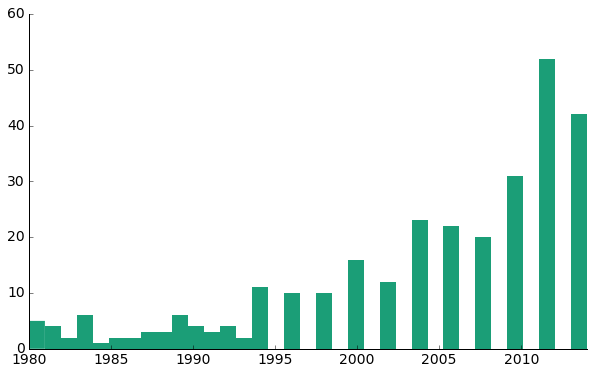

In [25]:
#distribution of the years in which respondents deceased
print min(deceased.values()), max(deceased.values())
plt.hist(deceased.values(), bins=35)
plt.xlim(min(deceased.values()), max(deceased.values()))
remove_border()

In [26]:
#add column year of death
sample_df['y_deceased'] = [deceased.get(i) for i in sample]
sample_df.head()

,caseid_1979,sample_id_1979,sample_race_1979,sample_sex_1979,c1dob_m_xrnd,c1dob_y_xrnd,c2dob_m_xrnd,c2dob_y_xrnd,c3dob_m_xrnd,c3dob_y_xrnd,...,c9dob_m_xrnd,c9dob_y_xrnd,c10dob_m_xrnd,c10dob_y_xrnd,c11dob_m_xrnd,c11dob_y_xrnd,y_dob,m_dob,y_age35,y_deceased
0,1,5,3,2,-4,-4,-4,-4,-4,-4,...,-4,-4,-4,-4,-4,-4,1958,9,1993,NaN
1,2,5,3,2,3,1993,11,1994,-4,-4,...,-4,-4,-4,-4,-4,-4,1959,1,1994,NaN
2,3,5,3,2,6,1981,10,1983,4,1986,...,-4,-4,-4,-4,-4,-4,1961,8,1996,NaN
3,4,5,3,2,8,1980,3,1997,-4,-4,...,-4,-4,-4,-4,-4,-4,1962,8,1997,NaN
4,8,6,3,2,3,1976,5,1979,9,1982,...,-4,-4,-4,-4,-4,-4,1958,7,1993,NaN


In [27]:
#determine last valid year
#last valid year is the year after which all rni stopped being -4
#-4 means the respondent was valid skip, i.e. interviewed
last_yr = []

for i in sample: #iterate through the sample

    #find the row in reason-noninterview dataframe that corresponds to the given id
    row = rni_df[rni_df.caseid_1979==i].iloc[0]
    
    # remove the first variable caseid_1979
    vals = row.values.tolist()[1:] 
    
    # find the last index -4 appeared
    if not -4 in vals: # respondent stopped participating since 1980, so last valid year is 1979
        last_yr.append(1979)
        
    else:
        last_ind = len(vals) - 1 - vals[::-1].index(-4) # last index at which -4 appeared
        
        #get the survey year from the variable name
        col_name = row.index[last_ind+1] # +1 because first variable caseid_1979
        last_yr.append(int(col_name[-4:]))
    
    
print set(last_yr)

set([1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1996, 1998, 2000, 2002, 2004, 2006, 2008, 2010, 2012, 2014])


In [28]:
#add last valid year as a new column to sample_df
sample_df['last_yr'] = last_yr
sample_df.head()

,caseid_1979,sample_id_1979,sample_race_1979,sample_sex_1979,c1dob_m_xrnd,c1dob_y_xrnd,c2dob_m_xrnd,c2dob_y_xrnd,c3dob_m_xrnd,c3dob_y_xrnd,...,c9dob_y_xrnd,c10dob_m_xrnd,c10dob_y_xrnd,c11dob_m_xrnd,c11dob_y_xrnd,y_dob,m_dob,y_age35,y_deceased,last_yr
0,1,5,3,2,-4,-4,-4,-4,-4,-4,...,-4,-4,-4,-4,-4,1958,9,1993,NaN,1981
1,2,5,3,2,3,1993,11,1994,-4,-4,...,-4,-4,-4,-4,-4,1959,1,1994,NaN,2014
2,3,5,3,2,6,1981,10,1983,4,1986,...,-4,-4,-4,-4,-4,1961,8,1996,NaN,2014
3,4,5,3,2,8,1980,3,1997,-4,-4,...,-4,-4,-4,-4,-4,1962,8,1997,NaN,1998
4,8,6,3,2,3,1976,5,1979,9,1982,...,-4,-4,-4,-4,-4,1958,7,1993,NaN,2014


In [29]:
#distribution of last valid year
sample_df.last_yr.value_counts()

2014    3656
2012     234
2010     149
2008     114
1998      99
2000      93
2004      75
2002      69
2006      61
1996      52
1994      52
1993      37
1989      26
1988      23
1991      23
1979      23
1987      18
1990      18
1992      18
1983      18
1984      18
1985      13
1982      12
1986      12
1981       7
1980       6
Name: last_yr, dtype: int64

In [30]:
def attr_before35(row):
    """
    Return True if respondent left study before turning age 35.
    Return False otherwise. 
    """
    return row['last_yr'] < row['y_age35']

sample_df['attr_before35'] = sample_df.apply(attr_before35, axis=1)
sample_df.attr_before35.value_counts()

False    4600
True      326
Name: attr_before35, dtype: int64

In [31]:
def deceased_before35(row):
    """Return True if respondent deceased before age 35."""
    
    if not np.isnan(row['y_deceased']): #if respondent deceased
        return row['y_deceased'] < row['y_age35']
    return False

sample_df['deceased_before35'] = sample_df.apply(deceased_before35, axis=1)
sample_df.deceased_before35.value_counts()

False    4870
True       56
Name: deceased_before35, dtype: int64

## Categories of respondents

In [32]:
#total number of female respondents
print sample_df.shape[0]

4926


In [33]:
count = defaultdict(int)

for i, row in sample_df.iterrows():
    
    if row['attr_before35']==True and row['deceased_before35']==True:
        count['attr, deceased'] += 1
        
    elif row['attr_before35']==True and row['deceased_before35']==False:
        count['attr, not deceased'] += 1
        
    elif row['attr_before35']==False and row['deceased_before35']==True: # impossible
        count['not attr, deceased'] += 1
        
    elif row['attr_before35']==False and row['deceased_before35']==False:
        count['not attr, not deceased'] += 1
        
print count

defaultdict(<type 'int'>, {'not attr, not deceased': 4600, 'attr, not deceased': 270, 'attr, deceased': 56})


In [34]:
#how many childless women who are observed through age 35?
#these women remained childless until the end of their reproductive years

print sample_df[(sample_df.c1dob_y_xrnd==-4)&(sample_df.attr_before35==False)].shape[0]
#print sample_df[(sample_df.c1dob_y_xrnd==-4)&(sample_df.attr_before35==False)&(sample_df.deceased_before35==False)].shape[0]

741


In [35]:
#childless women who deceased before age 35
#These women could have had children, but were unobserved

#We need to find whether the women remained childless until the end of their reproductive years or their death, 
#whichever came first 
 
print sample_df[(sample_df.c1dob_y_xrnd==-4)&(sample_df.deceased_before35==True)].shape[0]

28


In [36]:
def get_year_child18(x):
    """
    Given child's year of birth, return the year in which the child turned age 18.
    If childless, return -4.
    """
    
    if x==-4:
        return x
    else:
        return x+18

sample_df['y_child18'] = sample_df.c1dob_y_xrnd.map(get_year_child18)

In [37]:
def decease_before_child18(row):
    """
    Return True if respondent deceased before her first child turned age 18.
    Return False otherwise. 
    """
    
    if row['y_child18'] == -4: #no child
        return False
    elif not np.isnan(row['y_deceased']):
        return row['y_deceased'] < row['y_child18']
    return False

sample_df['deceased_child18'] = sample_df.apply(decease_before_child18, axis=1)

In [38]:
#mothers who deceased before child turned 18
sample_df[(sample_df.c1dob_m_xrnd>0)&(sample_df.deceased_child18==True)].shape[0]

54

In [39]:
#the following respondents should be excluded from the denominator when calculating missing cases:
# - respondents who remained childless and were observed until the end of their reproduction years
# - respondents who were childless and died before age 35
# - respondents who had children and died before child turned age 18

to_drop = sample_df[(sample_df.c1dob_y_xrnd==-4)&(sample_df.attr_before35==False)]['caseid_1979'].values.tolist() \
            + sample_df[(sample_df.c1dob_y_xrnd==-4)&(sample_df.deceased_before35==True)]['caseid_1979'].values.tolist() \
            + sample_df[(sample_df.c1dob_m_xrnd>0)&(sample_df.deceased_child18==True)]['caseid_1979'].values.tolist()

#denominator sample dataframe
denom_df = sample_df[~sample_df.caseid_1979.isin(to_drop)]
print denom_df.shape

(4103, 35)


In [40]:
#the birth year of first birth present in the dataset
denom_df.c1dob_y_xrnd.unique()

array([  -4, 1993, 1981, 1980, 1976, 1983, 1989, 1990, 1987, 1988, 1982,
       1994, 1985, 1979, 1996, 1977, 1986, 1992, 1991, 1978, 1984, 1999,
       1995, 1975, 1974, 1998, 1973, 1997, 1971, 2002, 2001, 2007, 2003,
       2006, 1972, 2004, 2000, 2005, 2011, 1970])

In [41]:
#number of women who had first birth too early - before 1980 (EXCLUSIVE)
#x = denom_df[(denom_df.c1dob_y_xrnd>0)&(denom_df.c1dob_y_xrnd<1980)].shape[0]
#print x,
#print x/float(denom_df.shape[0])

In [42]:
#number of women who had first birth too late - after 1995 (EXCLUSIVE)
#too late - because we can't observe 18 years of sequences after first childbirth
y = denom_df[denom_df.c1dob_y_xrnd>1995].shape[0]
print y
print y/float(denom_df.shape[0])

210
0.0511820619059


In [43]:
#women who never had children and attrited at some point before they turned 35 - end of reproductive years
childless_df = denom_df[denom_df.c1dob_y_xrnd==-4]
print childless_df.shape[0]
print childless_df.shape[0]/float(denom_df.shape[0])

130
0.0316841335608


## Select analytic sample for main analysis

In [44]:
#select mothers who had first birth before 1994 (inclusive)
analytic_df = denom_df[(denom_df.c1dob_y_xrnd>0)&(denom_df.c1dob_y_xrnd<=1995)]
print analytic_df.shape

(3763, 35)


In [45]:
#whether respondents attrited the study before first child turning 18
def attr_before_child18(row):
    """
    Return True if respondent left study before her first child turned age 18.
    Return False otherwise. 
    """
    
    return row['last_yr'] < row['y_child18']

analytic_df['attr_child18'] = analytic_df.apply(attr_before_child18, axis=1)

/Users/xzhuo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [46]:
#distribution of attrition before first child turning age 18
analytic_df.attr_child18.value_counts()

False    3434
True      329
Name: attr_child18, dtype: int64

In [47]:
# what percentage attributed before first child turned age 18?
print analytic_df[analytic_df.attr_child18==True].shape[0]/float(analytic_df.shape[0])

0.0874302418283


In [48]:
#select only women who remained in the study at least until their first child turned 18
analytic_df = analytic_df[analytic_df.attr_child18==False]
print analytic_df.shape

(3434, 36)


In [49]:
#does every mother have valid child birth dates? One respondent doesn't

for i, row in analytic_df.iterrows():
    for j in range(1, 12):
        if (row['c%sdob_y_xrnd'%j]<0 and row['c%sdob_y_xrnd'%j]!=-4) or (row['c%sdob_m_xrnd'%j]<0 and row['c%sdob_m_xrnd'%j]!=-4):
            print row['caseid_1979']

8511


In [50]:
# check variables for respondent id 8511
analytic_df[analytic_df.caseid_1979==8511].iloc[0]

caseid_1979           8511
sample_id_1979          13
sample_race_1979         2
sample_sex_1979          2
c1dob_m_xrnd             3
c1dob_y_xrnd          1990
c2dob_m_xrnd            11
c2dob_y_xrnd          1994
c3dob_m_xrnd             7
c3dob_y_xrnd          1998
c4dob_m_xrnd            -1
c4dob_y_xrnd          2001
c5dob_m_xrnd            -4
c5dob_y_xrnd            -4
c6dob_m_xrnd            -4
c6dob_y_xrnd            -4
c7dob_m_xrnd            -4
c7dob_y_xrnd            -4
c8dob_m_xrnd            -4
c8dob_y_xrnd            -4
c9dob_m_xrnd            -4
c9dob_y_xrnd            -4
c10dob_m_xrnd           -4
c10dob_y_xrnd           -4
c11dob_m_xrnd           -4
c11dob_y_xrnd           -4
y_dob                 1962
m_dob                    1
y_age35               1997
y_deceased             NaN
last_yr               2014
attr_before35        False
deceased_before35    False
y_child18             2008
deceased_child18     False
attr_child18         False
Name: 4049, dtype: object

**Update (6/15/2017)**: Respondent 8511 has a missing value for c4dob_m_xrnd. Previously, we decided to remove her, but now we decided to keep her. The missing birth month affects the construction of work sequences. We will see whether she took any leave in 1998, if had leave, assume birth happened that month (although be careful how many spells of leaves we got). Otherwise, assume birth happened in June. 
<br /><br />
The final sample consists of 3434 mothers.

In [51]:
# export to csv
analytic_df.to_csv('../data/analytic_df.csv', index=False)

In [52]:
#distribution of birth years in the final analytic sample
analytic_df.c1dob_y_xrnd.value_counts()

1980    283
1981    258
1982    256
1979    242
1983    226
1984    206
1985    204
1978    185
1986    171
1977    152
1988    147
1989    144
1976    139
1987    135
1990    121
1975    110
1991     94
1992     86
1993     83
1994     55
1974     52
1995     45
1973     28
1972      8
1971      3
1970      1
Name: c1dob_y_xrnd, dtype: int64

## Select sample for 14-year-sequence analysis

In [53]:
analytic_df14 = sample_df[(sample_df.c1dob_y_xrnd>0)&(sample_df.c1dob_y_xrnd<=1999)]
print analytic_df14.shape

(3969, 35)


In [54]:
analytic_df14['y_child14'] = analytic_df14.c1dob_y_xrnd.map(lambda x: x+14)
analytic_df14.head()

/Users/xzhuo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,caseid_1979,sample_id_1979,sample_race_1979,sample_sex_1979,c1dob_m_xrnd,c1dob_y_xrnd,c2dob_m_xrnd,c2dob_y_xrnd,c3dob_m_xrnd,c3dob_y_xrnd,...,y_dob,m_dob,y_age35,y_deceased,last_yr,attr_before35,deceased_before35,y_child18,deceased_child18,y_child14
1,2,5,3,2,3,1993,11,1994,-4,-4,...,1959,1,1994,NaN,2014,False,False,2011,False,2007
2,3,5,3,2,6,1981,10,1983,4,1986,...,1961,8,1996,NaN,2014,False,False,1999,False,1995
3,4,5,3,2,8,1980,3,1997,-4,-4,...,1962,8,1997,NaN,1998,False,False,1998,False,1994
4,8,6,3,2,3,1976,5,1979,9,1982,...,1958,7,1993,NaN,2014,False,False,1994,False,1990
5,10,6,3,2,1,1983,7,1988,-4,-4,...,1960,10,1995,NaN,1994,True,False,2001,False,1997


In [55]:
def attr_before_child14(row):
    """
    Return True if respondent left study before her first child turned age 14.
    Return False otherwise. 
    """
    return row['last_yr'] < row['y_child14']

analytic_df14['attr_child14'] = analytic_df14.apply(attr_before_child14, axis=1)
analytic_df14.head()

/Users/xzhuo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,caseid_1979,sample_id_1979,sample_race_1979,sample_sex_1979,c1dob_m_xrnd,c1dob_y_xrnd,c2dob_m_xrnd,c2dob_y_xrnd,c3dob_m_xrnd,c3dob_y_xrnd,...,m_dob,y_age35,y_deceased,last_yr,attr_before35,deceased_before35,y_child18,deceased_child18,y_child14,attr_child14
1,2,5,3,2,3,1993,11,1994,-4,-4,...,1,1994,NaN,2014,False,False,2011,False,2007,False
2,3,5,3,2,6,1981,10,1983,4,1986,...,8,1996,NaN,2014,False,False,1999,False,1995,False
3,4,5,3,2,8,1980,3,1997,-4,-4,...,8,1997,NaN,1998,False,False,1998,False,1994,False
4,8,6,3,2,3,1976,5,1979,9,1982,...,7,1993,NaN,2014,False,False,1994,False,1990,False
5,10,6,3,2,1,1983,7,1988,-4,-4,...,10,1995,NaN,1994,True,False,2001,False,1997,True


In [56]:
analytic_df14.attr_child14.value_counts()

False    3682
True      287
Name: attr_child14, dtype: int64

In [57]:
analytic_df14 = analytic_df14[analytic_df14.attr_child14==False]
print analytic_df14.shape

(3682, 37)


In [58]:
#does every mother have valid child birth dates? One doesn't. The same one
for i, row in analytic_df14.iterrows():
    for j in range(1, 12):
        if (row['c%sdob_y_xrnd'%j]<0 and row['c%sdob_y_xrnd'%j]!=-4) or (row['c%sdob_m_xrnd'%j]<0 and row['c%sdob_m_xrnd'%j]!=-4):
            print row['caseid_1979']

8511


In [59]:
analytic_df14.c1dob_y_xrnd.value_counts()

1980    289
1982    265
1981    264
1979    246
1983    233
1985    218
1984    216
1978    187
1986    180
1977    158
1989    151
1988    150
1976    141
1987    137
1990    124
1975    111
1991    100
1992     92
1993     87
1994     59
1974     52
1995     49
1996     43
1997     39
1973     29
1998     28
1999     22
1972      8
1971      3
1970      1
Name: c1dob_y_xrnd, dtype: int64

In [60]:
analytic_df14.to_csv('../data/analytic_df_seq14.csv', index=False)